In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

import wandb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from pytorch_forecasting.data import TimeSeriesDataSet

import netCDF4

In [2]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 512 if AVAIL_GPUS else 64

In [3]:
pl.seed_everything(125)

Global seed set to 125


125

## Load Data

In [4]:
sho = netCDF4.Dataset('../data/sho.nc').variables
t_sho = np.array(sho['t'][:], dtype=np.float32)
s_sho = np.array(sho['s'][:], dtype=np.float32)
v_sho = np.array(sho['v'][:], dtype=np.float32)

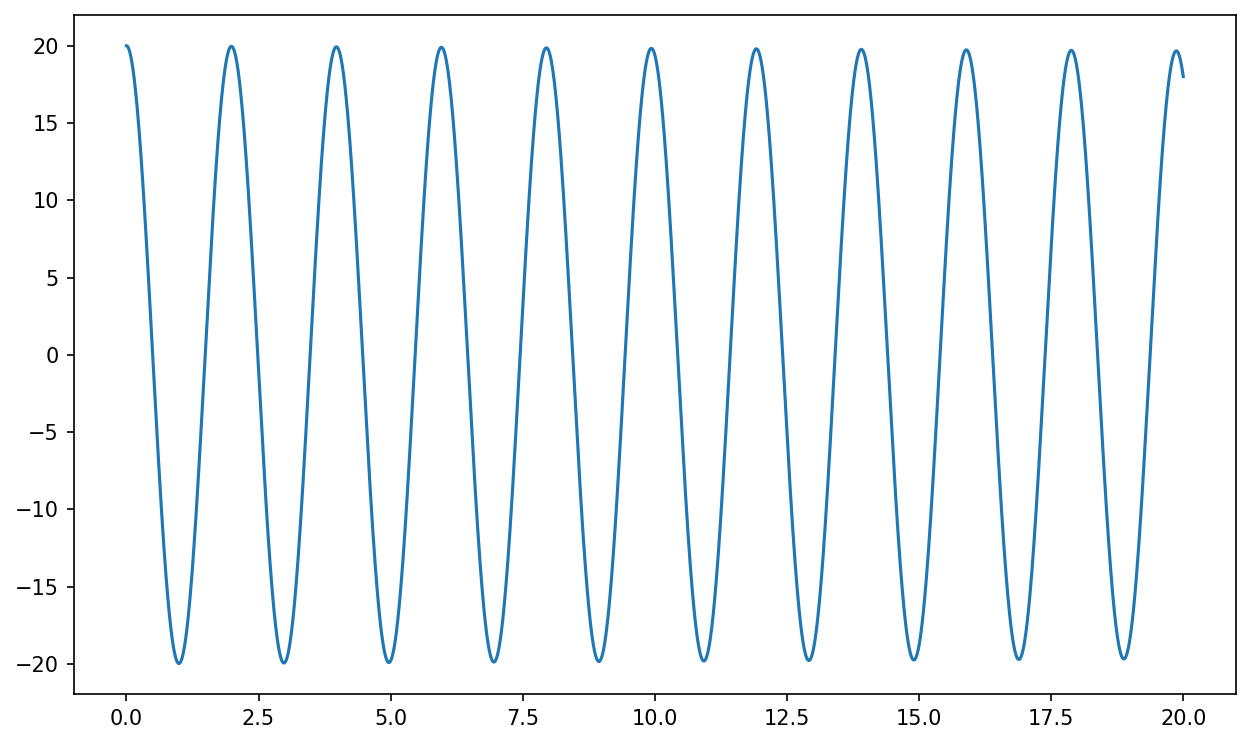

In [5]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, s_sho)
plt.show()

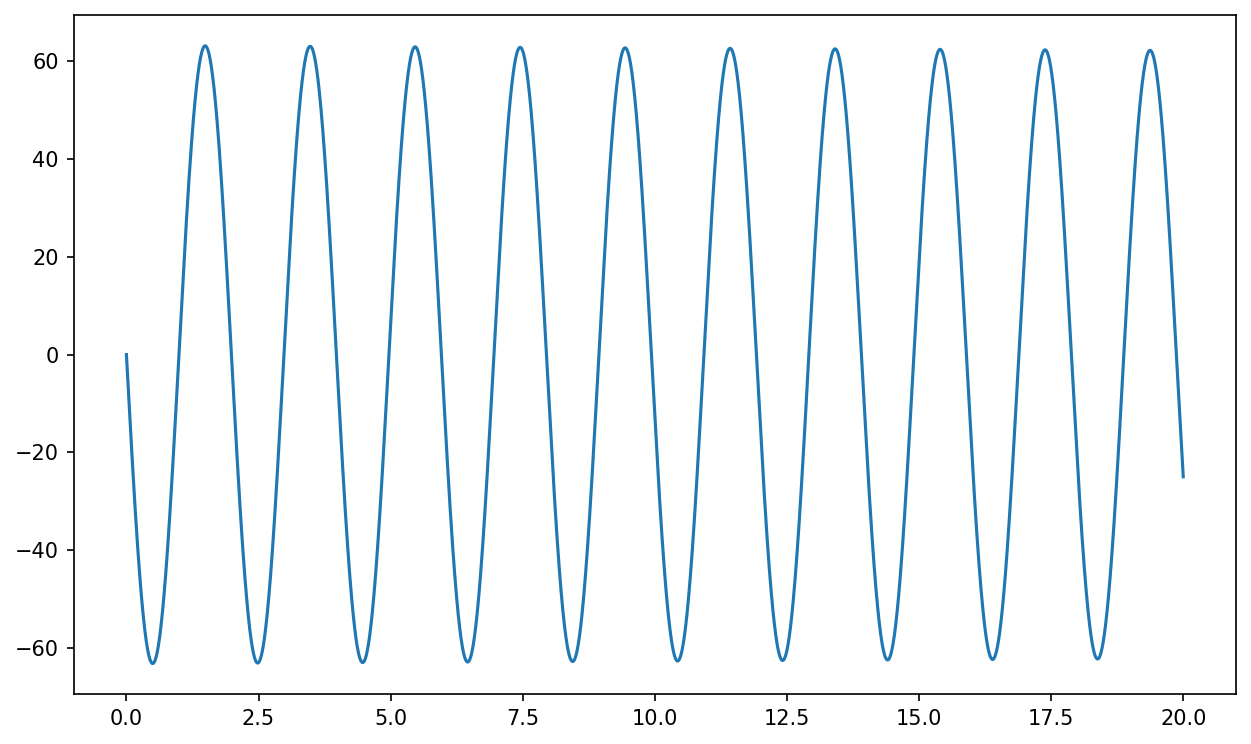

In [6]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, v_sho)
plt.show()

In [7]:
X_total = np.column_stack([s_sho, v_sho])
sc = MinMaxScaler()
X_normalized = sc.fit_transform(X_total)

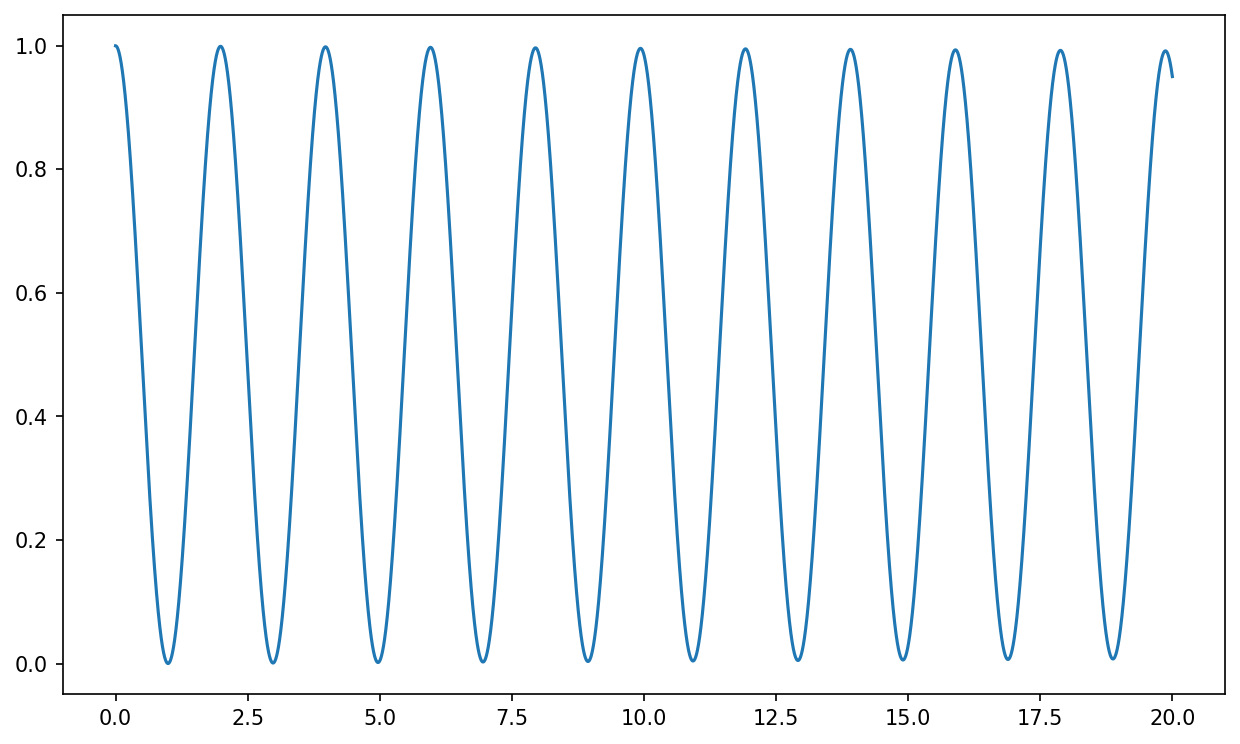

In [8]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, X_normalized[:,0])
plt.show()

In [9]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [10]:
X, y = sliding_window(X_normalized, 10)

In [11]:
X.shape

(19990, 10, 2)

In [12]:
y.shape

(19990, 2)

In [13]:
N = X.shape[0]
N_train = N // 100 * 75
N_test = N - N_train

X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

In [14]:
class NewtonData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
ds_ff_train = NewtonData(X_train, y_train)

In [16]:
len(ds_ff_train)

14925

In [17]:
test_lstm = nn.LSTM(input_size=2, hidden_size=10, num_layers=1)

In [18]:
test_dl = DataLoader(ds_ff_train, batch_size=100)

In [19]:
ds_ff_train[0]

(array([[1.        , 0.5002068 ],
        [0.9999971 , 0.49862438],
        [0.99998915, 0.49704194],
        [0.9999763 , 0.49545956],
        [0.99995834, 0.49387723],
        [0.9999354 , 0.49229494],
        [0.99990743, 0.49071273],
        [0.99987453, 0.48913065],
        [0.9998366 , 0.48754865],
        [0.9997937 , 0.4859668 ]], dtype=float32),
 array([0.9997457, 0.4843851], dtype=float32))

In [20]:
for ds in test_dl:
    X, y = ds
    out, hc = test_lstm(X)
    print(out.shape)
    print(out[:,-1].shape)
    break

torch.Size([100, 10, 10])
torch.Size([100, 10])


In [21]:
class LSTMForecast(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=1, # s, v
            hidden_size=256,
            num_layers=1,
            batch_first=True
        )
        
        self.linear = nn.Linear(256, 1)
        
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.epochs = hparams['epochs']
        
    def forward(self, x):
        lstm_out,  _ = self.lstm(x)
        pred = self.linear(lstm_out[:,-1])
        return pred
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        
        y_hat = self(X)
        loss = F.mse_loss(y, y_hat)
        
        self.log('train_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        
        y_hat = self(X)
        loss = F.mse_loss(y, y_hat)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), self.learning_rate)
        
    def prepare_data(self):
        sho = netCDF4.Dataset('../data/sho.nc').variables
        t_sho = np.array(sho['t'][:], dtype=np.float32)
        s_sho = np.array(sho['s'][:], dtype=np.float32)
        v_sho = np.array(sho['v'][:], dtype=np.float32)
        
#         X = np.column_stack([s_sho,v_sho])
        X = s_sho.reshape((-1, 1))
        sc = MinMaxScaler()
        X = sc.fit_transform(X)
        
        X, y = sliding_window(X, 10)
        
        N = X.shape[0]
        N_train = N // 100 * 75
        
        X_train = X[:N_train]
        X_test = X[N_train:]
        y_train = y[:N_train]
        y_test = y[N_train:]
        
        self.ds_train = NewtonData(X_train, y_train)
        self.ds_test = NewtonData(X_test, y_test)
        
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [22]:
hparams = {
    "learning_rate": 1e-3,
    "batch_size": BATCH_SIZE,
    "epochs": 100
}

model = LSTMForecast(
    hparams=hparams
)

wandb_logger = WandbLogger(
    project='Newton'
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=hparams['epochs'],
    gpus=AVAIL_GPUS,
    enable_progress_bar=False,
)

wandb: Currently logged in as: axect (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xteca/.local/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:183: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 265 K 
1 | linear | Linear | 257   
----------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.062     Total estimated model params size (MB)
/home/xteca/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/xteca/.local/lib/python3.10/site-packages/pytorch_ligh

In [24]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.00228
trainer/global_step,2999
val_loss,0.3237
